In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

#### Load GloVe embeddings

In [3]:
embeddings_index = {}

f = open ('glove.6B.100d.txt','r', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word]=coefs

f.close()
print ('Found %s word embeddings'%(len(embeddings_index)))

Found 400000 word embeddings


### Load comments

In [4]:
input_texts = []
target_texts = []

for line in open('./data/poetry/robert_frost.txt'):
    line = line.rstrip()
    input_line = '<sos> '+line
    target_line = line+' <eos>'
    input_texts.append(input_line)
    target_texts.append(target_line)
    
all_lines = input_texts + target_texts

In [5]:
MAX_WORDS=20000
BATCH_SIZE=122
EPOCHS=500
OOV_TOKEN=0
EMBEDDING_DIM = 100
MAX_SEQ_LENGTH=100
VALIDATION_SPLIT_RATIO= 0.2
LSTM_UNITS=500

### Tokenize comments

In [6]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_WORDS, oov_token=OOV_TOKEN, filters='')
tokenizer.fit_on_texts(all_lines)
word2Idx = tokenizer.word_index

print ('Found %d unique words'%(len(word2Idx)))
print (word2Idx['girl'])

input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)
print ('Found %d input sequences'%(len(input_sequences)))
print ('Found %d output sequences'%(len(target_sequences)))

max_seq_len_from_data = min (MAX_SEQ_LENGTH, max(len(s) for s in input_sequences))
print ('max seq length is %d'%(max_seq_len_from_data))

padded_input_sequences = tf.keras.preprocessing.sequence.pad_sequences(input_sequences, padding='post', maxlen=max_seq_len_from_data)
padded_target_sequences = tf.keras.preprocessing.sequence.pad_sequences(target_sequences, padding='post', maxlen=max_seq_len_from_data)

print ('Created %d padded input sequences'%(len(padded_input_sequences)))
print ('Created %d padded target sequences'%(len(padded_target_sequences)))

assert ('<sos>' in word2Idx)
assert ('<eos>' in word2Idx)

Found 3057 unique words
1374
Found 1581 input sequences
Found 1581 output sequences
max seq length is 12
Created 1581 padded input sequences
Created 1581 padded target sequences


In [7]:
num_words = min (MAX_WORDS, len(word2Idx)+1)
print ('Min words to be considered are %d'%(num_words))

loaded_embeddings_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word2Idx.items():
    if (i<num_words):
        if word in embeddings_index.keys():
            embedding_vector = embeddings_index[word]
            loaded_embeddings_matrix[i] = embedding_vector

print (loaded_embeddings_matrix.shape)

Min words to be considered are 3058
(3058, 100)


In [8]:
for i, seq in enumerate(padded_target_sequences):
    print (seq)
    if (i>2):
        break

[105 538 539  10   8 540 541   3   0   0   0   0]
[  6 542   7  66  32 935 142   3   0   0   0   0]
[  6  28  25 936 153   7 222   3   0   0   0   0]
[  6 168  68  25  18 129  18   7  66   3   0   0]


### Important Step:

If we look at this problem statement, we have a set of input sequences and corresponding target sequences.

Input Seq (T*D)-> Target Seq (T'*D')

    T -> number of input sequences
    D -> length of each input sequence

    T' -> number of target sequences
    D' -> length of each target sequence.

In a seq2seq scenario the target value needs to be one-hot encoded and that's what we are doing below.

In [9]:
one_hot_targets = np.zeros((len(target_sequences), max_seq_len_from_data, num_words))
print (one_hot_targets.shape)
for i, seq in enumerate(padded_target_sequences):
    for j, word in enumerate(seq):
        if (word>0):
            one_hot_targets[i,j,word]=1

(1581, 12, 3058)


### Build Model

In [10]:
embed_layer = tf.keras.layers.Embedding(input_dim = num_words,
                               output_dim = EMBEDDING_DIM,
                               input_length=max_seq_len_from_data, 
                               embeddings_initializer=tf.keras.initializers.Constant(loaded_embeddings_matrix),
                               trainable=True)

In [11]:
input_ = tf.keras.layers.Input(shape=(max_seq_len_from_data))
initial_h = tf.keras.layers.Input(shape=(LSTM_UNITS,))
initial_c = tf.keras.layers.Input(shape=(LSTM_UNITS,))

x = embed_layer(input_)

lstm_layer_0 = tf.keras.layers.LSTM(units=LSTM_UNITS, return_sequences=True, return_state=True)
x,_,_ = lstm_layer_0(x)

#stm_layer_1 = tf.keras.layers.LSTM(units=LSTM_UNITS, return_sequences=True, return_state=True)
#x,_,_ = lstm_layer_1(x)

dense_layer = tf.keras.layers.Dense(num_words, activation='softmax')
output = dense_layer(x)

model = tf.keras.models.Model([input_, initial_h, initial_c], output)

model.compile (optimizer=tf.keras.optimizers.Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

W0914 00:37:55.884897 13104 deprecation.py:506] From C:\MachineLearning\anaconda\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 12, 100)      305800      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 12, 500), (N 1202000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 500)]        0                                            
______________________________________________________________________________________________

In [12]:
h = np.zeros((len(padded_input_sequences),LSTM_UNITS))
c = np.zeros((len(padded_input_sequences),LSTM_UNITS))
history = model.fit ([padded_input_sequences,h,c], one_hot_targets, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT_RATIO)

W0914 00:37:56.228919 13104 deprecation.py:323] From C:\MachineLearning\anaconda\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1264 samples, validate on 317 samples
1264/1264 [==============================] - 9s 7ms/sample - loss: 4.7269 - acc: 0.0708 - val_loss: 4.8074 - val_acc: 0.0904


# Visualize the Training Metadata (Accuracy & Loss)

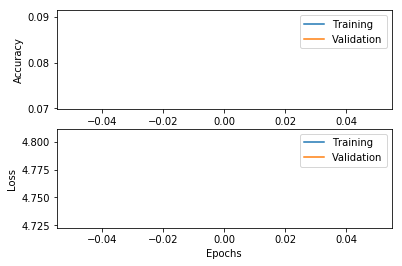

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

figure = plt.figure()

ax1 = figure.add_subplot(211)
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(labels=['Training','Validation'])

ax1 = figure.add_subplot(212)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(labels=['Training','Validation'])

plt.show()

### Prediction Model

In [14]:
input2_ = tf.keras.layers.Input(shape=(1,))

x = embed_layer(input2_)
x,h,c = lstm_layer_0(x, initial_state = [initial_h, initial_c])
#x,h,c = lstm_layer_1(x)

output2_ = dense_layer(x)

pred_model = tf.keras.models.Model([input2_, initial_h, initial_c], [output2_,h,c])
pred_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             305800      input_4[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 500)]        0                                            
____________________________________________________________________________________________

In [18]:
test_input_word = '<sos>'
test_input_word_idx = word2Idx[test_input_word]
test_input_word_vector = np.array([[test_input_word_idx]])

print (test_input_word_vector.shape)

h = np.zeros((1,LSTM_UNITS))
c = np.zeros((1,LSTM_UNITS))

output_poem = []
eos = word2Idx['<eos>']
idx2word = {v:k for k, v in word2Idx.items()}

for i in range(max_seq_len_from_data):
    
    o,h,c = pred_model.predict([test_input_word_vector, h, c])
    
    probs = o[0,0]
    if (np.argmax(probs)==0):
        print ('hell!')
    probs[0] = 0
    probs = probs/probs.sum()
    
    idx = np.random.choice(len(probs), p=probs)
    if (idx == eos):
        break
    
    test_input_word_vector[0,0] = idx
    
    output_poem.append(idx2word.get(idx) + ' ')
    
print (output_poem)

(1, 1)
['what- ', 'there ', 'outdoors. ', 'attic, ', 'no ', 'it, ', 'ourselves ', 'cellar. ', 'skulls ', "aren't ", 'of ']
